In [23]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# tsfresh functions
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [24]:
df = pd.read_csv('AirPassengers.csv', usecols=[1])
df.shape

(144, 1)

In [25]:
middle_point = 120 
data_train = np.array(df.iloc[:middle_point]).squeeze()
data_test = np.array(df[middle_point:]).squeeze()
data = np.concatenate([data_train, data_test])

In [26]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'oob'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 10
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 10
params['dynamic'] = False

In [59]:
def plot_results(time_series,train_prediction, test_prediction, y_test):
    
    """
    Plots the original time series and it prediction
    """
    
    train_pr = train_prediction
    test_pr = test_prediction
    ts = time_series
    
    plt.figure(figsize=(10,7))

    plt.plot(ts, label = "true")
    
    plt.plot(np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=119, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

In [28]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=True,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=True,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [75]:
my_dict_of_features = {'spkt_welch_density':[{'coeff': 1}], 'absolute_sum_of_changes':None, 'maximum': None,
                      'fft_coefficient':[{"coeff": 1, "attr": 'real'}], 'kurtosis':None, 
                       'agg_linear_trend':[{"attr": 'pvalue', "chunk_len": 1, "f_agg": 'mean'},
                                           {"attr": 'pvalue', "chunk_len": 1, "f_agg": 'max'}],
                      'number_peaks':[{'n':5}],'skewness': None,'count_below_mean':None }

In [76]:
def fit_rolling_pyramid(y_train, max_timeshift = 10, rolling_direction = 1, params = None, my_dict_of_features=None):

    df_shift, y = make_forecasting_frame(y_train, kind = "price", 
                        max_timeshift = max_timeshift, rolling_direction = rolling_direction)
    X_train = extract_features(df_shift, column_id="id", column_sort="time", 
                                    column_value="value", impute_function=impute, show_warnings=False,
                                  default_fc_parameters = my_dict_of_features,disable_progressbar = True)
    X_train.dropna(axis = 1, inplace = True)
    exog_df = X_train[:-1]
    X_train = np.array(X_train)
    ts = y_train[2:]
    exog = X_train[:-1]
    last_exog = X_train[-1]
    model = fit_pyramid(data_train=ts, exog_train=exog,params = params)
    predict_in_sample = model.predict_in_sample(exogenous = exog)
    return model, last_exog, predict_in_sample, exog_df

In [77]:
 def predict_rolling_pyramid_2(model, last_exog, y_train, forecast_horizont, 
                               max_timeshift = 10, rolling_direction = 1, my_dict_of_features =None):
        
        """
        Predicting values on the next forecast_horizont values
        """
        predictions = np.empty(forecast_horizont)
        predictions[0] = model.predict(n_periods = 1, exogenous = last_exog.reshape(1,-1))
        merged_exog = last_exog.reshape(1,-1)
        for it in range(1,forecast_horizont):
            
            y_train_tmp = np.append(y_train, predictions[it-1])
            df_shift, y = make_forecasting_frame(y_train_tmp, kind = "price", 
                            max_timeshift = max_timeshift, rolling_direction = rolling_direction)
        
            X_train = extract_features(df_shift, default_fc_parameters = my_dict_of_features,
                                       column_id="id", column_sort="time", disable_progressbar = True,
                    column_value="value", impute_function=impute, show_warnings=False)
        
            X_train.dropna(axis = 1, inplace = True)
            X_train = np.array(X_train)
            #print (X_train.shape)
            ts_tmp =y_train_tmp[2:]
            exog_tmp = X_train[-1].reshape(1,-1)
            merged_exog = np.vstack((merged_exog, exog_tmp))
            
            y_pred = model.predict(n_periods = it+1, exogenous = merged_exog)
        
        predictions = y_pred
        
        return predictions

In [78]:
model, last, predict_in_sample, Exog = fit_rolling_pyramid(y_train=data_train, params=params,
                                                           my_dict_of_features=my_dict_of_features)

/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:388: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  differences = df.groupby(grouper)[column_sort].apply(
/home/nurlan16/anaconda3/lib/python3.6/site-packages/tsfresh/utilities/dataframe_functions.py:400: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  grouped_data = df.groupby(grouper)


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1136.095, BIC=1169.344, Fit time=0.390 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=1001.675, BIC=1040.465, Fit time=1.265 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=1092.768, BIC=1131.558, Fit time=0.785 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1129.601, BIC=1165.620, Fit time=0.182 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=990.099, BIC=1031.660, Fit time=2.588 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=1062.557, BIC=1106.887, Fit time=2.059 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(3, 0, 1, 12); AIC=1059.432, BIC=1106.534, Fit time=4.422 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=1010.298, BIC=1049.088, Fit time=2.267 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=1050.712, BIC=1095.043, Fit time=2.632 seconds
Fit ARIMA: order=(1, 0, 1) se

In [79]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  118
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -480.050
Date:                            Tue, 24 Jul 2018   AIC                            990.099
Time:                                    18:10:22   BIC                           1031.660
Sample:                                         0   HQIC                          1006.974
                                            - 118                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3523      1.561      0.866      0.386      -1.707       4.412
x1             0.0677      0.096      0.704      0.481      -0.121       0.256
x2            23.6855      2.984      7.937      0.000      17.837      29.534
x3            23.6855      2.984      7.937      0.000      17.837      29.534
x4            -4.6424      1.912     -2.429      0.015      -8.389      -0.896
x5             0.0082      0.059      0.139      0.889      -0.107       0.124
x6             1.1218      2.566      0.437      0.662      -3.908       6.151
x7             0.7941      0.128      6.207      0.000       0.543       1.045
const               0   9175.121          0      1.000    -1.8e+04     1.8e+04
x8            -1.8901      6.203     -0.305      0.761     -14.048      10.268
x9            -0.0033      0.001     -2.383      0.017      -0.006      -0.001
ar.L1          0.6868      0.096      7.141      0.000       0.498       0.875
ar.S.L12       0.3657      0.086      4.271      0.000       0.198       0.534
ar.S.L24       0.5638      0.094      6.019      0.000       0.380       0.747
sigma2       168.8547     34.230      4.933      0.000     101.764     235.945
===================================================================================
Ljung-Box (Q):                       47.22   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.20   Prob(JB):                         0.14
Heteroskedasticity (H):               1.27   Skew:                             0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.34e+23. Standard errors may be unstable.
"""

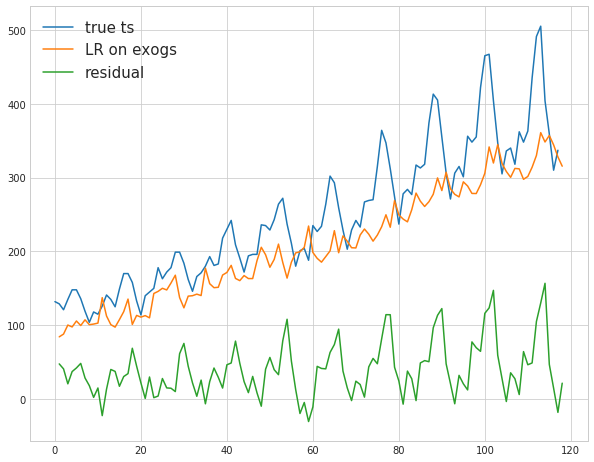

In [80]:
ex_params = model.params()[1:-4]
direct_ts = Exog @ ex_params.T 
residual = data_train[2:] - direct_ts

plt.figure(figsize=(10,8))
plt.plot(data_train[2:], label = "true ts")
plt.plot(direct_ts, label = "LR on exogs")
plt.plot(residual,label = "residual")
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [81]:
%%capture
predictions = predict_rolling_pyramid_2(model,last,data_train,24, my_dict_of_features=my_dict_of_features)

In [82]:
predictions

array([337.41252041, 326.23079128, 386.22389312, 376.69224161,
       375.76550424, 425.99191194, 439.75542434, 463.21120739,
       373.71709048, 374.09842009, 344.71231956, 381.17766388,
       374.84760668, 359.31969967, 414.07900518, 400.56156754,
       401.60829322, 421.81322655, 440.97809538, 464.59792136,
       369.94380932, 341.00771821, 311.80600761, 347.44816491])

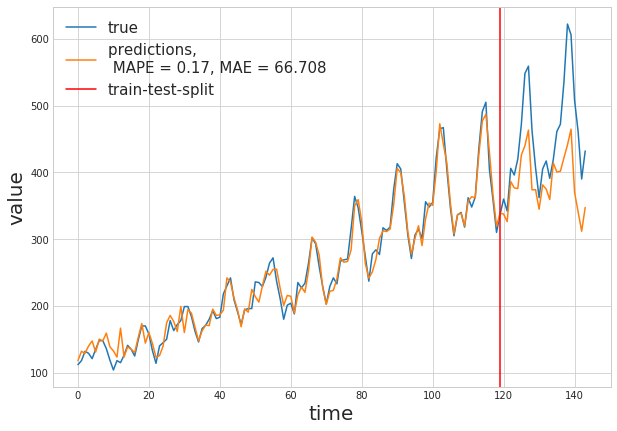

In [83]:
plot_results(data,np.concatenate([data[:4],predict_in_sample[1:]]),predictions,data_test)